## Regression Analysis

In [8]:
%%capture
import math
import pickle
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import scipy.stats as ss
import statsmodels.api as sm
import scikit_posthocs as sp
from stargazer.stargazer import Stargazer
from statsmodels.base.wrapper import ResultsWrapper
from math import sqrt
from statsmodels.regression.linear_model import RegressionResults
from linearmodels import RandomEffects, PanelOLS, BetweenOLS
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from matplotlib import rc
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from cycler import cycler
tqdm().pandas()

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path    = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
output_path  = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data     = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"

class MyStargazer(Stargazer):
    def __init__(self, models):
        super().__init__(models)
        
    def extract_model_data(self, model):
        statsmodels_map = {'p_values' : 'pvalues',
                           'cov_values' : 'params',
                           'cov_std_err' : 'tvalues',   # change from 'bse' to 'tvalues' to report t-values in brackets
                           'r2' : 'rsquared',
                           'r2_adj' : 'rsquared_adj',
                           'f_p_value' : 'f_pvalue',
                           'degree_freedom' : 'df_model',
                           'degree_freedom_resid' : 'df_resid',
                           'nobs' : 'nobs',
                           'f_statistic' : 'fvalue'
                           }

        data = {}
        for key, val in statsmodels_map.items():
            data[key] = self._extract_feature(model, val)

        if isinstance(model, ResultsWrapper):
            data['cov_names'] = model.params.index.values
        else:
            # Simple RegressionResults, for instance as a result of
            # get_robustcov_results():
            data['cov_names'] = model.model.data.orig_exog.columns

            # These are simple arrays, not Series:
            for what in 'cov_values', 'p_values', 'cov_std_err':
                data[what] = pd.Series(data[what],
                                       index=data['cov_names'])

        data['conf_int_low_values'] = model.conf_int()[0]
        data['conf_int_high_values'] = model.conf_int()[1]
        data['resid_std_err'] = (sqrt(sum(model.resid**2) / model.df_resid)
                                 if hasattr(model, 'resid') else None)

        # Workaround for
        # https://github.com/statsmodels/statsmodels/issues/6778:
        if 'f_statistic' in data:
            data['f_statistic'] = (lambda x : x[0, 0] if getattr(x, 'ndim', 0)
                                   else x)(data['f_statistic'])

        return data

Load Data 

In [2]:
idiosync_returns = True
idiosync = '_idiosync' if idiosync_returns else ''
abn      = '_abn' if idiosync_returns else '' 

sp500 = pd.read_csv(fin_data+'SPCOMP_1990_2022.csv', sep=';', index_col=0)
sp500.index = pd.to_datetime(sp500.index) 
sp500['TOT RETURN OPEN'] = (sp500['OPENING PRICE']/sp500['PRICE INDEX'])*sp500['TOT RETURN IND']
sp500_r = sp500.pct_change()  
sp500_r['TR OpenClose'] = (sp500['TOT RETURN IND']  - sp500['TOT RETURN OPEN'])/sp500['TOT RETURN OPEN']
sp500_r['TR CloseOpen'] = (sp500['TOT RETURN OPEN'] - sp500['TOT RETURN IND'].shift(1))/sp500['TOT RETURN IND'].shift(1)
sp500_r = sp500_r.reset_index()

vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.rename(columns={'date':'Date'})
vix['vix_tm1'] = vix.vix.shift(1)

# Load Fama Frensh Data
fama_french = pd.read_csv(fin_data+'F-F_Research_Data_5_Factors_2x3_daily.csv', header=2, encoding='utf-8', index_col=0)
fama_french.index = pd.to_datetime(fama_french.index, format='%Y%m%d')
fama_french.index.name = 'Date'
fama_french = fama_french.rename(columns={'Mkt-RF':'Mkt_RF'})
fama_french = fama_french.loc[datetime(1995,12,28):]
fama_french = fama_french/100

beta = pd.read_csv(fin_data+'beta_mc_to_mc_df_2022.csv')     
beta.Date = pd.to_datetime(beta.Date)
beta = beta.set_index('Date')
beta = beta.stack()
beta = beta.reset_index()
beta.columns = ['Date', 'Ticker', 'Beta']

r_mc_to_mo = pd.read_csv(fin_data + f"Datastream/Data/return_mc_to_mo{idiosync}.csv", index_col=0)                 
r_mc_to_mo.index = pd.to_datetime(r_mc_to_mo.index)                                                        
r_mc_to_mo = r_mc_to_mo.replace([np.inf, -np.inf, 0.00000], np.nan)
r_mc_to_mo = r_mc_to_mo.stack()
r_mc_to_mo.index.names = ['Date', 'Ticker']
r_mc_to_mo.name = 'return_mc_to_mo_t'

r_mc_to_mc = pd.read_csv(fin_data + f"Datastream/Data/return_mc_to_mc{idiosync}.csv", index_col=0)           
r_mc_to_mc.index = pd.to_datetime(r_mc_to_mc.index)                                                        
r_mc_to_mc = r_mc_to_mc.replace([np.inf, -np.inf, 0.00000], np.nan)              
r_mc_to_mc = r_mc_to_mc[r_mc_to_mc.apply(lambda x: sum(x.isna()), axis=1) < 0.8*r_mc_to_mc.shape[1]] # Drop rows with more than 80% NaN values
r_mc_to_mc = r_mc_to_mc.stack(dropna=True, level=0)
r_mc_to_mc.index.names = ['Date', 'Ticker']
r_mc_to_mc.name = 'return_mc_to_mc_t'

event_data = pd.read_csv(f'./Data/event_data{abn}_returns_mo_to_mc_17_5h_z_val_idiosync_no_dupl_2002-2021_v2.csv', encoding='utf-8')
event_data.Date = pd.to_datetime(event_data.Date)
event_data = event_data.set_index('Date')

dataset = event_data.loc[:, ['Ticker', 'z_value', 'Sentiment', 'return_t', 'topic_1', 'topic_2']]
dataset = dataset.rename(columns={'return_t':'return_mo_to_mc_t'})
dataset = dataset.set_index('Ticker', append=True)
dataset = pd.merge(left=dataset, right=r_mc_to_mo, left_index=True, right_index=True, how='left')
dataset = pd.merge(left=dataset, right=r_mc_to_mc, left_index=True, right_index=True, how='left')
dataset = dataset.reset_index()
dataset = pd.merge(left=dataset, right=vix[['Date', 'vix_tm1']], on='Date', how='left')
dataset = pd.merge(left=dataset, right=sp500_r[['Date', 'TR CloseOpen']], on='Date', how='left')
dataset = dataset.rename(columns={'z_value':'z_value_tm1'})

# Add column with z_values(t) from z_values(t-1)
alldates = np.unique(dataset.Date)
alldates = pd.DataFrame(data={'Date':alldates, 'Date_Index': np.arange(0, len(alldates))})
temp1 = pd.merge(left=dataset.loc[:, ['Date', 'Ticker', 'z_value_tm1']], right=alldates, on='Date', how='left')
temp1 = temp1.rename(columns={'z_value_tm1':'z_value_t'})
temp1 = temp1[['Ticker', 'Date_Index', 'z_value_t']]
temp1 = temp1.set_index(['Date_Index', 'Ticker'])

dataset = pd.merge(left=dataset, right=alldates, on='Date', how='left')
dataset['Date_Index_Merge'] = dataset.Date_Index+1
dataset = pd.merge(left=dataset, right=temp1, left_on=['Date_Index_Merge', 'Ticker'], right_index=True, how='left')
dataset = dataset.drop(['Date_Index', 'Date_Index_Merge'], axis=1)

# Merge with FamaFrench Factors
dataset = pd.merge(left=dataset, right=fama_french, on='Date', how='left')

# Calculate Beta adjusted returns
dataset = pd.merge(left=dataset, right=beta, on=['Date', 'Ticker'], how='left')
#dataset['beta_adj_return_mo_to_mc_t'] = dataset.return_mo_to_mc_t * dataset.Beta

In [3]:
start_date = datetime(2002,1,1)
end_date   = datetime(2020,12,31)
min_vix    = 0
max_vix    = 150
min_topic1 = 0
min_topic2 = 0

sCrit = 0.45
zCrit = 1.645

def dummy_variable(x, limit):
    if x >= limit:
        return 1
    elif x <= -limit:
        return -1
    else:
        return 0
    
    
cols  = ['Date', 'Ticker', 'z_value_tm1', 'vix_tm1', 'TR CloseOpen', 'Sentiment', 'return_mc_to_mo_t', 'return_mo_to_mc_t', 'return_mc_to_mc_t', 'z_value_t', 'topic_1', 'topic_2', 'Beta', 'Mkt_RF', 'SMB', 'HML']

X_y = dataset.copy()
X_y = X_y.replace(np.nan, 0)
X_y = X_y.loc[((X_y.Date >= start_date)    & 
               (X_y.Date <  end_date)      &
               (X_y.topic_1 >= min_topic1) & 
               (X_y.topic_2 >= min_topic2) &
               (X_y.vix_tm1 >= min_vix)    &
               (X_y.vix_tm1 <= max_vix)), cols].copy()


#X_y = X_y.loc[abs(X_y.Sentiment) > 0].reset_index(drop=True)     # Consider only events where Sentiment is available 
X_y.Date = X_y.Date.dt.year

X_y.insert(0, 'intercept', 1)
X_y.insert(2, 'z_value_tm1^2', X_y.z_value_tm1.apply(lambda x: x**2))
X_y.insert(3, 'iz_value_tm1',  X_y.z_value_tm1.apply(dummy_variable, args=([zCrit])))
X_y.insert(6, 'abs(Sentiment)', X_y.Sentiment.abs())
X_y.insert(7, 'iSentiment', X_y.Sentiment.apply(dummy_variable, args=([sCrit])))
X_y.insert(8, 'iStrongSentiment', X_y.iSentiment.abs())
X_y.insert(9, 'z_val_tm1 x Sentiment', X_y.z_value_tm1 * X_y.Sentiment)
X_y.insert(10,'z_val_tm1 x abs(Sentiment)', X_y.z_value_tm1 * X_y.Sentiment.abs())
X_y.insert(11,'z_val_tm1^2 x Sentiment', (X_y.z_value_tm1**2) * X_y.Sentiment)

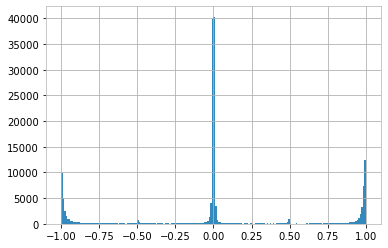

In [4]:
(X_y.Sentiment.loc[abs(X_y.Sentiment)>0]).hist(bins=200)
plt.show()

In [119]:
dep_vars = ['return_mc_to_mo_t', 'return_mo_to_mc_t']
#features = ['intercept', 'z_value_tm1', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']#, 'z_val_tm1^2 x Sentiment']
features = ['intercept', 'z_value_tm1', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']#, 'z_val_tm1^2 x Sentiment', 'vix_tm1', 'TR CloseOpen']

#features = ['intercept', 'z_value_tm1', 'Sentiment', 'abs(Sentiment)', 'z_val_tm1 x Sentiment', 'z_val_tm1 x abs(Sentiment)']
#features = ['intercept', 'Mkt_RF', 'SMB', 'HML', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']

filter1 = slice(None)
#filter1 = ((X_y.z_value_tm1>0) & (X_y.Sentiment<0))

In [120]:
lm = {}
for y in dep_vars:
    lm[y] = sm.OLS(X_y.loc[filter1, y], X_y.loc[filter1, features]).fit()
    print(f"R-Squared: {lm[y].rsquared:.5f}\nAdj. R-Squared: {lm[y].rsquared_adj:.5f}")
    print(lm[y].summary())

R-Squared: 0.02190
Adj. R-Squared: 0.02189
                            OLS Regression Results                            
Dep. Variable:      return_mc_to_mo_t   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 1.734e+04
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:59:19   Log-Likelihood:             7.1490e+06
No. Observations:             2323806   AIC:                        -1.430e+07
Df Residuals:                 2323802   BIC:                        -1.430e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [121]:
stargazer = MyStargazer([lm['return_mc_to_mo_t'], lm['return_mo_to_mc_t']])
    
stargazer.significant_digits(4)
stargazer.custom_columns(['(a)', '(b)'], [1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(features)
stargazer.show_degrees_of_freedom(False)
display(HTML(stargazer.render_html()))

In [122]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{(a)} & \multicolumn{1}{c}{(b)}  \\
\hline \\[-1.8ex]
 intercept & 0.0002$^{***}$ & -0.0001$^{***}$ \\
  & (25.1640) & (-10.6379) \\
 z_value_tm1 & -0.0000$^{}$ & -0.0002$^{***}$ \\
  & (-1.0167) & (-17.7359) \\
 Sentiment & 0.0108$^{***}$ & 0.0003$^{***}$ \\
  & (227.6782) & (4.4519) \\
 z_val_tm1 x abs(Sentiment) & -0.0001$^{***}$ & -0.0005$^{***}$ \\
  & (-3.2297) & (-9.0546) \\
\hline \\[-1.8ex]
 Observations & 2,323,806 & 2,323,806 \\
 $R^2$ & 0.0219 & 0.0002 \\
 Adjusted $R^2$ & 0.0219 & 0.0002 \\
 Residual Std. Error & 0.0112 & 0.0168  \\
 F Statistic & 17339.7211$^{***}$  & 168.5781$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# 
**Panel Regression**

https://bashtage.github.io/linearmodels/panel/introduction.html

In [62]:
year = pd.Categorical(X_y.Date)
X_y_panel_reg = X_y.set_index(['Ticker', 'Date'])
X_y_panel_reg['year'] = year
X_y_panel_reg.head()

,,intercept,z_value_tm1^2,iz_value_tm1,z_value_tm1,abs(Sentiment),iSentiment,iStrongSentiment,z_val_tm1 x Sentiment,z_val_tm1 x abs(Sentiment),z_val_tm1^2 x Sentiment,vix_tm1,TR CloseOpen,Sentiment,return_mc_to_mo_t,return_mo_to_mc_t,return_mc_to_mc_t,z_value_t,topic_1,topic_2,Beta,Mkt_RF,SMB,HML,year
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,
TER,2002,1,0.602930,0,0.776486,0.0,0,0,0.0,0.0,0.0,21.83,0.002667,0.0,0.011536,0.006982,0.018311,0.135989,0.0,0.0,0.0,-0.0045,0.0008,-0.0011,2002
WMTT,2002,1,1.353024,0,-1.163196,0.0,0,0,-0.0,-0.0,0.0,21.83,0.002667,0.0,-0.005252,-0.015756,-0.020898,-1.288105,0.0,0.0,0.0,-0.0045,0.0008,-0.0011,2002
BSX,2002,1,0.177993,0,0.421892,0.0,0,0,0.0,0.0,0.0,21.83,0.002667,0.0,-0.010484,0.000000,-0.006836,0.000000,0.0,0.0,0.0,-0.0045,0.0008,-0.0011,2002
MET,2002,1,0.006956,0,0.083402,0.0,0,0,0.0,0.0,0.0,21.83,0.002667,0.0,-0.001463,0.007544,0.006117,0.532542,0.0,0.0,0.0,-0.0045,0.0008,-0.0011,2002
AWE,2002,1,0.639128,0,-0.799455,0.0,0,0,-0.0,-0.0,0.0,21.83,0.002667,0.0,0.000638,-0.032141,-0.031554,-1.109070,0.0,0.0,0.0,-0.0045,0.0008,-0.0011,2002


In [133]:
features = ['intercept', 'z_value_tm1', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']
y = 'return_mo_to_mc_t'
fixed_effects = ['None', 'Firm', 'Date', 'Firm \& Date']
lm = {}

for effect in fixed_effects:
    if effect == 'Firm':
        entity, time = True, False
    elif effect == 'Date':
        entity, time = False, True
    elif effect == 'Firm \& Date':
        entity, time = True, True
    else:
        entity, time = False, False
    
    # Panel OLS
    model = PanelOLS(X_y_panel_reg[y], X_y_panel_reg[features], entity_effects=entity, time_effects=time, drop_absorbed=True)
    lm[effect] = model.fit()



# RandomEffects OLS
#mod = RandomEffects(X_y_panel_reg[y], X_y_panel_reg[features])
#re_res = mod.fit()

# Between OLS
#mod = BetweenOLS(X_y_panel_reg[y], X_y_panel_reg[features])
#re_res = mod.fit(reweight=True)

In [155]:
# Print as latex
effect = 'None'
print('r-squared:', round(lm[effect].rsquared, 5))
#print('adj. r-squared:', round(lm[effect].rsquared_adj, 5))

print(lm[effect].summary)

r-squared: 0.00022
                          PanelOLS Estimation Summary                           
Dep. Variable:      return_mo_to_mc_t   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0184
No. Observations:             2323806   R-squared (Within):               0.0002
Date:                Mon, Jun 27 2022   R-squared (Overall):              0.0002
Time:                        10:57:00   Log-likelihood                 6.195e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      168.58
Entities:                         874   P-value                           0.0000
Avg Obs:                       2658.8   Distribution:               F(3,2323802)
Min Obs:                       12.000                                           
Max Obs:                       4701.0   F-statistic (robust):             168.58
         

In [128]:
lm['Firm'].variance_decomposition
#re_res.theta.head()

Effects                   4.294904e-07
Residual                  2.826409e-04
Percent due to Effects    1.517257e-03
Name: Variance Decomposition, dtype: float64

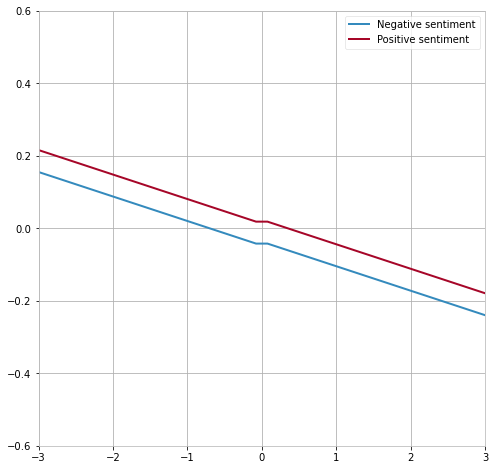

In [87]:
ylim = 0.6
xlim = 3.0
z_score_range = [(-xlim,0), (0,xlim)]
sentiment     = {'neg': -0.95, 'pos': 0.95}
vix_value    = 10
TR_CloseOpen = 0.01
k = 20
j = 0
y_pred = {}

for s in sentiment.keys():
    y_pred[s] = np.array([])    
    for z in z_score_range:
        z_vals = np.linspace(z[0], z[1], k)
        X_pred = np.c_[np.ones(k), 
                       z_vals, 
                       [sentiment[s]]*k, 
                       z_vals*np.array([abs(sentiment[s])]*k), 
                       #(z_vals**2)*np.array([sentiment[s]]*k),
                       #[vix_value]*k, 
                       #[TR_CloseOpen]*k
                      ]
        
        y_pred[s] = np.hstack((y_pred[s], lm['return_mo_to_mc_t'].predict(X_pred)))       
        j+=1
        
        
xaxis = np.linspace(z_score_range[0][0], z_score_range[-1][-1], 2*k)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(xaxis, y_pred['neg']*100, label='Negative sentiment')
ax.plot(xaxis, y_pred['pos']*100, label='Positive sentiment')
ax.set_ylim([-ylim, ylim])
ax.set_xlim([-xlim, xlim])
plt.legend()
plt.show()

## 
**Post-Hoc Tests**

In [45]:
y = 'return_mo_to_mc_t'
sCrit = 0.45
zCrit = 0.5

Kruskal-Wallis Test

In [46]:
ss.kruskal(X_y.loc[((X_y.z_value_tm1 < -zCrit) & (X_y.Sentiment >  0)), y].values,
           X_y.loc[((X_y.z_value_tm1 < -zCrit) & (X_y.Sentiment <  0)), y].values,
           X_y.loc[((X_y.z_value_tm1 < -zCrit) & (X_y.Sentiment)== 0), y].values)

KruskalResult(statistic=141.38909215155147, pvalue=1.984946193136824e-31)

In [47]:
ss.kruskal(X_y.loc[((X_y.z_value_tm1 > zCrit) & (X_y.Sentiment >  0)), y].values,
           X_y.loc[((X_y.z_value_tm1 > zCrit) & (X_y.Sentiment <  0)), y].values,
           X_y.loc[((X_y.z_value_tm1 > zCrit) & (X_y.Sentiment)== 0), y].values)

KruskalResult(statistic=135.06118206342586, pvalue=4.697177320092636e-30)

Dunn's Test

In [48]:
X_y['si'] = X_y.Sentiment.apply(lambda x: 'negative sentiment' if x < -sCrit 
                                else('positive sentiment' if x > sCrit else 'neutral sentiment'))

In [49]:
sp.posthoc_dunn(X_y.loc[(X_y.z_value_tm1 < -zCrit)], val_col=y, group_col='si')#, p_adjust='holm')

,negative sentiment,neutral sentiment,positive sentiment
negative sentiment,1.000000,0.020254,0.203334
neutral sentiment,0.020254,1.000000,0.000036
positive sentiment,0.203334,0.000036,1.000000


In [50]:
sp.posthoc_dunn(X_y.loc[(X_y.z_value_tm1 > zCrit)], val_col=y, group_col='si')#, p_adjust='holm')

,negative sentiment,neutral sentiment,positive sentiment
negative sentiment,1.000000e+00,2.303520e-12,0.002597
neutral sentiment,2.303520e-12,1.000000e+00,0.000421
positive sentiment,2.596873e-03,4.214015e-04,1.000000


## 
Individuall Regressions for each Case

In [11]:
start_date = datetime(2002,1,1)
end_date   = datetime(2020,12,31)
min_vix    = 0
max_vix    = 150
filter_case, model = {}, {}
cols = ['Ticker', 'z_value_tm1', 'vix_tm1', 'Sentiment', 'return_mc_to_mo_t', 'return_mo_to_mc_t', 'return_mc_to_mc_t', 'z_value_t', 'Beta', 'Mkt_RF', 'SMB', 'HML']

X_y = dataset.loc[((dataset.Date >= start_date) & 
                   (dataset.Date <  end_date)   &
                   (dataset.vix_tm1  >= min_vix)    &
                   (dataset.vix_tm1  <= max_vix)), cols].copy()

X_y = X_y.replace(np.nan, 0)
X_y.insert(0, 'intercept', 1)
X_y.insert(2, 'z_value_tm1^2', X_y.z_value_tm1.apply(lambda x: x**2))
X_y.insert(3, 'iz_value_tm1',  X_y.z_value_tm1.apply(dummy_variable, args=([zCrit])))
X_y.insert(6, 'abs(Sentiment)', X_y.Sentiment.abs())
X_y.insert(7, 'iSentiment', X_y.Sentiment.apply(dummy_variable, args=([sCrit])))
X_y.insert(8, 'iStrongSentiment', X_y.iSentiment.abs())
X_y.insert(9, 'z_val_tm1 x Sentiment', X_y.z_value_tm1 * X_y.Sentiment)
X_y.insert(10,'z_val_tm1 x abs(Sentiment)', X_y.z_value_tm1 * X_y.Sentiment.abs())
X_y.insert(11,'z_val_tm1^2 x Sentiment', (X_y.z_value_tm1**2) * X_y.Sentiment)
X_y.head(2)

,intercept,Ticker,z_value_tm1^2,iz_value_tm1,z_value_tm1,vix_tm1,abs(Sentiment),iSentiment,iStrongSentiment,z_val_tm1 x Sentiment,z_val_tm1 x abs(Sentiment),z_val_tm1^2 x Sentiment,Sentiment,return_mc_to_mo_t,return_mo_to_mc_t,return_mc_to_mc_t,z_value_t,Beta,Mkt_RF,SMB,HML
0,1,PKI,0.0,0,0.0,22.129999,0.0,0,0,0.0,0.0,0.0,0.0,0.006684,-0.020518,-0.013948,0.0,0.0,0.0008,-0.0007,0.002
1,1,EW,0.0,0,0.0,22.129999,0.0,0,0,0.0,0.0,0.0,0.0,-0.001655,-0.006184,-0.007782,0.0,0.0,0.0008,-0.0007,0.002


In [14]:
#features  = ['intercept', 'z_val_tm1 x abs(Sentiment)']
#features  = ['intercept', 'z_value', 'Sentiment', 'z_val x Sentiment']
#features  = ['intercept', 'Sentiment', 'z_val_tm1 x abs(Sentiment)',  'z_val_tm1^2 x Sentiment']
features   = ['intercept', 'z_value_tm1', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']#, 'z_val_tm1^2 x Sentiment']
z_features = ['intercept', 'z_value_tm1']

s_Crit     = 0.45
y = ['return_mo_to_mc_t']

filter_case['NEG NEG'] = ((X_y.Sentiment<s_Crit)  & (X_y.z_value_tm1<0))                            
filter_case['NEG POS'] = ((X_y.Sentiment<s_Crit)  & (X_y.z_value_tm1>0))                              
filter_case['POS NEG'] = ((X_y.Sentiment>s_Crit)  & (X_y.z_value_tm1<0))                                
filter_case['POS POS'] = ((X_y.Sentiment>s_Crit)  & (X_y.z_value_tm1>0))    
filter_case['___ NEG'] = ((X_y.Sentiment==0) & (X_y.z_value_tm1<0))                
filter_case['___ POS'] = ((X_y.Sentiment==0) & (X_y.z_value_tm1>0))           


for case in filter_case.keys():      
    if re.findall('___', case):
        lm[case] = sm.OLS(X_y.loc[filter_case[case], y], X_y.loc[filter_case[case], z_features]).fit()
    else:
        lm[case] = sm.OLS(X_y.loc[filter_case[case], y], X_y.loc[filter_case[case], features]).fit()
        
    
stargazer = MyStargazer([lm['NEG NEG'], lm['NEG POS'], lm['POS NEG'], lm['POS POS'], lm['___ NEG'], lm['___ POS']])
stargazer.significant_digits(4)
stargazer.custom_columns(['Sentiment N, z-score N', 'Sentiment N, z-score P', 'Sentiment P, z-score N', 'Sentiment P, z-score P', 'z-score N', 'z-score P'], [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(True)
stargazer.covariate_order(features)
stargazer.show_degrees_of_freedom(False)
display(HTML(stargazer.render_html()))

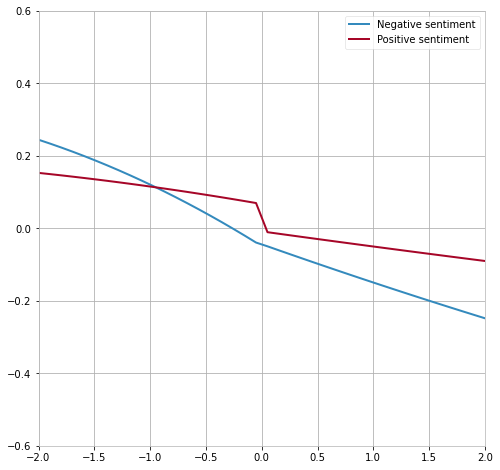

In [13]:
z_score_range = [(-2,0), (0,2)]
sentiment     = {'neg': -0.95, 'pos': 0.95}

k = 20
j = 0
y_pred = {}

for s in sentiment.keys():
    y_pred[s] = np.array([])    
    for z in z_score_range:
        z_vals = np.linspace(z[0], z[1], k)
        A = 'NEG' if sentiment[s] < 0 else 'POS'
        B = 'NEG' if z_vals.mean() < 0 else 'POS'
        X_pred = np.c_[np.ones(k), z_vals, [sentiment[s]]*k, z_vals*np.array([abs(sentiment[s])]*k),  (z_vals**2)*np.array([sentiment[s]]*k)]
        y_pred[s] = np.hstack((y_pred[s], lm[f'{A} {B}'].predict(X_pred)))       
        j+=1
        
        
ylim  = .6     
xaxis = np.linspace(z_score_range[0][0], z_score_range[-1][-1], 2*k)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(xaxis, y_pred['neg']*100, label='Negative sentiment')
ax.plot(xaxis, y_pred['pos']*100, label='Positive sentiment')
ax.set_ylim([-ylim, ylim])
ax.set_xlim([-2, 2])
plt.legend()
plt.show()

In [709]:
# Make Return Predictions
z = 1    # z-score
s = -1   # news sentiment

A = 'NEG' if s < 0 else 'POS'
B = 'NEG' if z < 0 else 'POS'
w = lm[f'{A} {B}'].params.values.reshape(-1,1) # weights
print(f"Predicted return: {100*(np.array([1, z, s, z*abs(s), (z**2)*s]) @ w)[0]:.4f}%")

Predicted return: -0.5720%


In [710]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{Sentiment N, z-score N} & \multicolumn{1}{c}{Sentiment N, z-score P} & \multicolumn{1}{c}{Sentiment P, z-score N} & \multicolumn{1}{c}{Sentiment P, z-score P} & \multicolumn{1}{c}{z-score N} & \multicolumn{1}{c}{z-score P}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\
\hline \\[-1.8ex]
 intercept & 0.0022$^{***}$ & 0.0004$^{}$ & 0.0012$^{**}$ & 0.0005$^{}$ & 0.0005$^{***}$ & -0.0000$^{}$ \\
  & (3.3673) & (0.5751) & (2.3626) & (0.9715) & (12.0361) & (-0.2091) \\
 z_value_tm1 & 0.0009$^{}$ & 0.0008$^{}$ & -0.0005$^{}$ & 0.0009$^{*}$ & -0.0007$^{***}$ & 0.0006$^{***}$ \\
  & (1.5771) & (1.4421) & (-1.1516) & (1.9148) & (-16.6100) & (16.3128) \\
 Sentiment & 0.0144$^{***}$ & 0.0155$^{***}$ & 0.0107$^{***}$ & 0.0133$^{***}$ & & \\
  & (13.2447) & (14.0953) & (10.7352) & (1

In [284]:
%%time
n_obs_min = 100   # Minimum number of observations for regression
ticker_list = sorted(list(set(X_y.Ticker)))
r_squared = {}
to_few_obs = []
for ticker in ticker_list:
    X_i = X_y.loc[X_y.Ticker==ticker, features]
    y_i = X_y.loc[X_y.Ticker==ticker, y]    
    if X_i.shape[0] < n_obs_min:
        to_few_obs.append(ticker)
        continue
    lm = sm.OLS(y_i, X_i).fit()
    r_squared[ticker] = lm.rsquared

r_squared_array = np.array(list(r_squared.values()))
r_squared_array = r_squared_array[np.isfinite(r_squared_array)]

CPU times: total: 2min 1s
Wall time: 20.2 s


In [285]:
# Median R^2 
print(f"Median R^2: {100*np.median(r_squared_array):.2f}%")

# -----------------------------------------------------
# Events where News Sentiment is available (~150k obs.)

# Normal Returns -------------------------
# close-to-close Return
# Median R^2: 31.00% (intercept + FF3)
# Median R^2: 47.09% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))
# Median R^2:  9.72% (intercept + z_value_tm1, Sentiment, abs(Sentiment), z_val_tm1 x Sentiment, z_val_tm1 x abs(Sentiment))

# open-to-close Return
# Median R^2: 16.89% (intercept + FF3)
# Median R^2: 20.30% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))
# Median R^2:  5.00% (intercept + z_value_tm1, Sentiment, abs(Sentiment), z_val_tm1 x Sentiment, z_val_tm1 x abs(Sentiment))


# Idiosyncratic Returns -------------------------
# close-to-close Return
# Median R^2:  6.34% (intercept + FF3)
# Median R^2: 13.33% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))
# Median R^2:  8.88% (intercept + z_value_tm1, Sentiment, abs(Sentiment), z_val_tm1 x Sentiment, z_val_tm1 x abs(Sentiment))

# open-to-close Return
# Median R^2:  7.43% (intercept + FF3)
# Median R^2: 10.31% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))
# Median R^2:  5.14% (intercept + z_value_tm1, Sentiment, abs(Sentiment), z_val_tm1 x Sentiment, z_val_tm1 x abs(Sentiment))



# -----------------------------------------------------
# All Events (~2Mio obs.)

# Normal Returns -------------------------
# close-to-close Return
# Median R^2: 34.14% (intercept + FF3)
# Median R^2: 36.39% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))

# Idiosyncratic Returns -------------------------

# open-to-close Return
# Median R^2: 4.82% (intercept + FF3)
# Median R^2: 5.93% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))

# close-to-close Return
# Median R^2: 4.82% (intercept + FF3)
# Median R^2: 5.93% (intercept + FF3 +  Sentiment + z_val_tm1 x abs(Sentiment))

Median R^2: 2.69%


**Explained Varaince in return_mo_to_mc**

In [210]:
y = ['return_mo_to_mc_t']
#features = ['intercept', 'z_value', 'Sentiment', 'z_val x Sentiment']
#features = ['intercept', 'z_value_tm1', 'abs(Sentiment)', 'z_val_tm1 x abs(Sentiment)']
#features = ['intercept', 'z_value_tm1', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']

features = ['intercept', 'z_value_tm1', 'Sentiment', 'abs(Sentiment)', 'z_val_tm1 x Sentiment', 'z_val_tm1 x abs(Sentiment)']
#features = ['intercept', 'Mkt_RF', 'SMB', 'HML', 'Sentiment', 'z_val_tm1 x abs(Sentiment)']

In [211]:
lm = sm.OLS(X_y.loc[:, y], X_y.loc[:, features]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      return_mo_to_mc_t   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     34.84
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           9.68e-36
Time:                        13:30:04   Log-Likelihood:             3.1750e+05
No. Observations:              154172   AIC:                        -6.350e+05
Df Residuals:                  154166   BIC:                        -6.349e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept           

In [212]:
return_mo_to_mc_t_pred = lm.predict(X_y.loc[:, features])

r  = X_y.return_mo_to_mc_t
dr = (X_y.return_mo_to_mc_t-return_mo_to_mc_t_pred)

var_ratio = r.var()/dr.var()
df1, df0  = len(r)-1, len(dr)-1
p_value   = 1 - stats.f.cdf(var_ratio, df1, df0)

print(f"Variance of r:  {100*r.var():.4f}%\nVariance of dr: {100*dr.var():.4f}%")
print(f"Variance Ratio: {1/var_ratio:.4f} (dr/r)")
print(f"p_value :       {p_value:.4f}")

Variance of r:  0.0953%
Variance of dr: 0.0952%
Variance Ratio: 0.9989 (dr/r)
p_value :       0.4123


In [236]:
%%time
ticker_list = sorted(list(set(X_y.Ticker)))
reg_stats_df = pd.DataFrame(index=ticker_list, columns=['var(r)', 'var(dr)', 'var_ratio', 'p_value'])
r_squared  = {}
to_few_obs = []
for ticker in ticker_list:
    X_i = X_y.loc[X_y.Ticker==ticker, features]
    y_i = X_y.loc[X_y.Ticker==ticker, y]
    if X_i.shape[0] < 100:
        to_few_obs.append(ticker)
        continue
    lm = sm.OLS(y_i, X_i).fit()

    return_mo_to_mc_t_pred = lm.predict(X_y.loc[X_y.Ticker==ticker, features])
    r  = (X_y.loc[X_y.Ticker==ticker, y[0]])
    dr = (X_y.loc[X_y.Ticker==ticker, y[0]] - return_mo_to_mc_t_pred)
    var_r, var_dr = r.var(), dr.var()
    var_ratio = var_r/var_dr
    df1, df0  = len(r)-1, len(dr)-1
    p_value   = 1 - stats.f.cdf(var_ratio, df1, df0)
    
    reg_stats_df.loc[ticker, :] = [var_r, var_dr, var_ratio, p_value]

CPU times: total: 4min 3s
Wall time: 41.5 s


In [240]:
reg_stats_df.dropna().median(axis=0)

var(r)       0.000808
var(dr)      0.000771
var_ratio    1.028356
p_value      0.418820
dtype: float64

## 
**No News**

In [215]:
X_y_no_news = dataset.loc[dataset.Sentiment.isna()].reset_index(drop=True)
X_y_no_news = X_y_no_news.loc[:, ['z_value_tm1', 'vix', 'return_mo_to_mc_t', 'return_mc_to_mo_t', 'z_value_t']].dropna()
X_y_no_news.insert(1, 'z_value_tm1^2', X_y_no_news.z_value_tm1.apply(lambda x: x**2))
X_y_no_news.insert(2, 'iz_value_tm1',  X_y_no_news.z_value_tm1.apply(dummy_variable, args=([zCrit])))

In [216]:
features = ['z_value_tm1', 'z_value_tm1^2']
y        = ['z_value_t']

lm = sm.OLS(X_y_no_news.loc[:, y], X_y_no_news.loc[:, features]).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:              z_value_t   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              131.8
Date:                Mon, 23 May 2022   Prob (F-statistic):                    5.76e-58
Time:                        14:28:40   Log-Likelihood:                     -2.7914e+06
No. Observations:             1934935   AIC:                                  5.583e+06
Df Residuals:                 1934933   BIC:                                  5.583e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## 
**Fama French Regression**

In [340]:
# Return Data
daily_returns = pd.read_csv(data_path + 'return_mc_to_mc.csv', index_col=0)           
daily_returns.index = pd.to_datetime(daily_returns.index)                                                        
daily_returns = daily_returns.replace([np.inf, -np.inf, 0.00000], np.nan)              
daily_returns = daily_returns[daily_returns.apply(lambda x: sum(x.isna()), axis=1) < 0.8*daily_returns.shape[1]] # Drop rows with more than 80% NaN values
daily_returns = daily_returns.stack(dropna=True, level=0)
daily_returns.index.names = ['Date', 'Ticker']
daily_returns.name = 'Return'
daily_returns = daily_returns.reset_index()

# Merge with FamaFrench Factors
dataset = pd.merge(left=daily_returns, right=fama_french.reset_index(), on='Date', how='left')
dataset.insert(3, 'intercept', 1)

dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset

,Date,Ticker,Return,intercept,Mkt_RF,SMB,HML,RMW,CMA,RF
0,1995-12-28,MLM,-0.011765,1,-0.0006,0.000,0.0034,0.0014,0.0005,0.00024
1,1995-12-28,ALB,0.006934,1,-0.0006,0.000,0.0034,0.0014,0.0005,0.00024
2,1995-12-28,QLGC,-0.015848,1,-0.0006,0.000,0.0034,0.0014,0.0005,0.00024
3,1995-12-28,WAI,0.002492,1,-0.0006,0.000,0.0034,0.0014,0.0005,0.00024
4,1995-12-28,AVB,0.020918,1,-0.0006,0.000,0.0034,0.0014,0.0005,0.00024
...,...,...,...,...,...,...,...,...,...,...
4670241,2020-11-20,NKE,0.008111,1,-0.0051,0.006,-0.0061,-0.0073,-0.0011,0.00000
4670242,2020-11-20,GL,-0.000643,1,-0.0051,0.006,-0.0061,-0.0073,-0.0011,0.00000
4670243,2020-11-20,FITB,-0.022798,1,-0.0051,0.006,-0.0061,-0.0073,-0.0011,0.00000
4670244,2020-11-20,HD,-0.004134,1,-0.0051,0.006,-0.0061,-0.0073,-0.0011,0.00000


In [349]:
ticker_list = list(set(dataset.Ticker))
r_squared = {}
for ticker in ticker_list:
    lm = sm.OLS(dataset.loc[dataset.Ticker==ticker, 'Return'], dataset.loc[dataset.Ticker==ticker, ['intercept', 'Mkt_RF', 'SMB', 'HML']]).fit()
    r_squared[ticker] = lm.rsquared
#print(lm.summary())

C:\Users\Stefa\anaconda3\envs\main\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [361]:
# Median R^2 
print(f"Median R^2: {100*np.median(np.array(list(r_squared.values()))):.2f}%")
#FF3: Median R^2: 26.36%

Median R^2: 26.36%
